<a href="https://colab.research.google.com/github/sudhakarmlal/EVA4/blob/master/Session10/utils/S10_api_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment S10
In this assignment Resnet architecture is used to train CIPHAR10 dataset and used Data Augmmentation. Developed APIs so as to load data, train, test and show results.

Following changes are done:

1. Added Data Augmentations (Albumentatons)
i. Cutout
ii. Horizontal Flip
iii. Gaussian Noise
iv. Elastic Transform  

3. Added L2 regularization
4. Added LRFinder to get good starting learning rate
5. Used ReduceLROnPlateau strategey for scheduling learning rates

Got best test accuracy: 88.80%


In [0]:
%matplotlib inline
import autoreload
%load_ext autoreload
%autoreload

In [0]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-kea3v616
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-kea3v616
     |████████████████████████████████| 634kB 8.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65100 sha256=fca6c301cbbc05effdf205bdcb68c07b94e308f60818b814f743e4670b358a83
  Stored in directory: /tmp/pip-ephem-wheel-cache-n7gt__r_/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=5a13f0be43dcf50995b3fc9e2967ae7fefada48b61f60789ad86fd138fece7ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-n7gt__r_/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: album

## Mount the google drive

In [0]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Copy all the API python files from the google drive to local folder

Follwing python files are imported from google drive. Purpsoe of these files are as below:

model.py - Defines the model class Net
train_test.py- API for training and testing
accuracy_utils - API foro getting test accuracy and per class accuracy
data_loader.py - API for loading train and test data
data_transform.py - API for transforming and normalizing data
plot_metrics.py - API for plotting metrics

In [0]:
!cp -rf '/content/drive/My Drive/eva_apis/data_loaders' .
!cp -rf '/content/drive/My Drive/eva_apis/data_transformations' .
!cp -rf '/content/drive/My Drive/eva_apis/models' .
!cp -rf '/content/drive/My Drive/eva_apis/utils' .

## Import all the libraries

In [0]:
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from data_transformations.data_transform_ciphar10_resnet import get_train_transform, get_test_transform
from data_loaders.ciphar10_data_loader import get_train_loader, get_test_loader, get_classes
from models.resnet18 import ResNet18
from utils.train_test_utils import train,test
from utils.accuracy_utils import get_test_accuracy,get_accuracy_per_class
from utils.plot_metrics_utils import plot_loss_accuracy,plot_accuracy

from utils.misclassified_image_utils import  display_misclassfied_ciphar10_images
from utils.gradcamkz_util import GRADCAM, PLOT,PLOTGRADCAM
from utils.gradcamkz_util import process_for_grad_cam





Training a Classifier
=====================



Training an image classifier
----------------------------

I have done the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





 ## 1. Loading and normalizing CIFAR10

 I have used APIs get_train_loader, get_test_loader to load train data and test data respectively. Both the APIs internally uses torchvision. I have used get_transform API to transform tensors in the range [-1,1]



In [0]:
transform_train = get_train_transform()
transform_test = get_test_transform()

trainloader = get_train_loader(256, transform_train)
testloader = get_test_loader(256, transform_test)
classes = get_classes()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualizing some of the images in train dataset



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck  frog   dog  bird


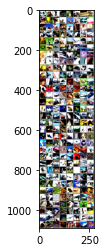

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network

I have defined the basic ResNet18 model and added dropout to it



In [0]:
!pip install torchsummary
from torchsummary import summary
model =  ResNet18()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.device = torch.device("cuda" if use_cuda else "cpu")
model =  ResNet18().to(model.device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         Dropout2d-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
         Dropout2d-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
        Dropout2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []



In [0]:
!pip install torch-lr-finder

## Use LRFinder to find good starting learning rate

- First use exponetial step mode to find good learning rate range between 0.001 and 10
- Increases the learning rate linearly and computes the evaluation loss for each learning rate (Leslie Smith's approach) to find the best starting learning rate

  pip install torch-lr-finder -v --global-option="amp"


/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)



Learning rate search finished. See the graph with {finder_name}.plot()


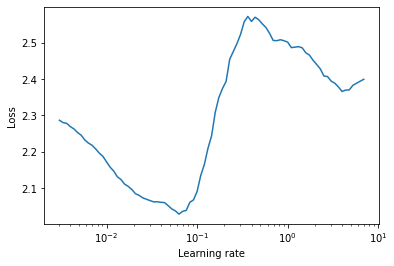

In [0]:
import torch.optim as optim
from torch_lr_finder import LRFinder

model =  ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)



Learning rate search finished. See the graph with {finder_name}.plot()


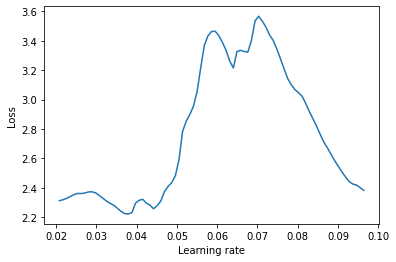

In [0]:
from torch_lr_finder import LRFinder

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=0.1, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

## Based on the plot we have chosen 0.04 as the initial learning rate

## 3. Define a Loss function and optimizer and train the model

I have used Classification Cross-Entropy loss and SGD with learning rate 0.04 with momentum 0.9.

## 4. Train the model

 I have used 100 epochs to train the model. Used ReduceLROnPlateau strategy with facotr 0.1 and patience 3

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import os

model =  ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9, weight_decay=0.0001)

EPOCHS = 50
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)


PATH = '/content/drive/My Drive/cifar10_resnet18_reduce_lr_plateau.pth'
torch.save(model.state_dict(), PATH)
best_test_accuracy = 0.0
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch, train_losses,train_acc )
    test(model, device, testloader, test_losses, test_acc)
    t_acc = test_acc[-1]
    if t_acc > best_test_accuracy:
        print("Test Accuracy: " + str(t_acc) + " has increased. Saving the model")
        best_test_accuracy = t_acc
        torch.save(model.state_dict(), PATH)
    
    scheduler.step(t_acc)

  0%|          | 0/196 [00:00<?, ?it/s]

EPOCH: 0


/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Loss=1.4788159132003784 Batch_id=195 Accuracy=39.54: 100%|██████████| 196/196 [00:29<00:00,  6.73it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.6649, Accuracy: 4495/10000 (44.95%)

Test Accuracy: 44.95 has increased. Saving the model
EPOCH: 1


Loss=1.0059988498687744 Batch_id=195 Accuracy=54.84: 100%|██████████| 196/196 [00:29<00:00,  6.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.0163, Accuracy: 6565/10000 (65.65%)

Test Accuracy: 65.65 has increased. Saving the model
EPOCH: 2


Loss=0.9434942007064819 Batch_id=195 Accuracy=63.86: 100%|██████████| 196/196 [00:29<00:00,  6.69it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.8111, Accuracy: 7214/10000 (72.14%)

Test Accuracy: 72.14 has increased. Saving the model
EPOCH: 3


Loss=0.923568844795227 Batch_id=195 Accuracy=69.28: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.0465, Accuracy: 6706/10000 (67.06%)

EPOCH: 4


Loss=0.8866066932678223 Batch_id=195 Accuracy=72.95: 100%|██████████| 196/196 [00:29<00:00,  6.74it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 1.0379, Accuracy: 6715/10000 (67.15%)

EPOCH: 5


Loss=0.5896663069725037 Batch_id=195 Accuracy=75.39: 100%|██████████| 196/196 [00:28<00:00,  6.76it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5823, Accuracy: 8026/10000 (80.26%)

Test Accuracy: 80.26 has increased. Saving the model
EPOCH: 6


Loss=0.7886285781860352 Batch_id=195 Accuracy=77.28: 100%|██████████| 196/196 [00:29<00:00,  6.68it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6921, Accuracy: 7844/10000 (78.44%)

EPOCH: 7


Loss=0.49160757660865784 Batch_id=195 Accuracy=79.46: 100%|██████████| 196/196 [00:29<00:00,  6.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7367, Accuracy: 7770/10000 (77.70%)

EPOCH: 8


Loss=0.41679033637046814 Batch_id=195 Accuracy=80.39: 100%|██████████| 196/196 [00:28<00:00,  6.78it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6337, Accuracy: 8110/10000 (81.10%)

Test Accuracy: 81.1 has increased. Saving the model
EPOCH: 9


Loss=0.4310689866542816 Batch_id=195 Accuracy=82.07: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6773, Accuracy: 8000/10000 (80.00%)

EPOCH: 10


Loss=0.4291706085205078 Batch_id=195 Accuracy=82.83: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6610, Accuracy: 8175/10000 (81.75%)

Test Accuracy: 81.75 has increased. Saving the model
EPOCH: 11


Loss=0.4297536313533783 Batch_id=195 Accuracy=83.55: 100%|██████████| 196/196 [00:29<00:00,  6.71it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7651, Accuracy: 7886/10000 (78.86%)

EPOCH: 12


Loss=0.2370925396680832 Batch_id=195 Accuracy=84.56: 100%|██████████| 196/196 [00:29<00:00,  6.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7416, Accuracy: 8058/10000 (80.58%)

EPOCH: 13


Loss=0.4211389124393463 Batch_id=195 Accuracy=84.82: 100%|██████████| 196/196 [00:29<00:00,  6.72it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6440, Accuracy: 8228/10000 (82.28%)

Test Accuracy: 82.28 has increased. Saving the model
EPOCH: 14


Loss=0.4728224277496338 Batch_id=195 Accuracy=85.45: 100%|██████████| 196/196 [00:29<00:00,  6.69it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6005, Accuracy: 8441/10000 (84.41%)

Test Accuracy: 84.41 has increased. Saving the model
EPOCH: 15


Loss=0.2555420398712158 Batch_id=195 Accuracy=85.74: 100%|██████████| 196/196 [00:29<00:00,  6.66it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6036, Accuracy: 8357/10000 (83.57%)

EPOCH: 16


Loss=0.4195984899997711 Batch_id=195 Accuracy=85.76: 100%|██████████| 196/196 [00:29<00:00,  6.71it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.5954, Accuracy: 8396/10000 (83.96%)

EPOCH: 17


Loss=0.38863784074783325 Batch_id=195 Accuracy=86.67: 100%|██████████| 196/196 [00:29<00:00,  6.75it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.7381, Accuracy: 8244/10000 (82.44%)

EPOCH: 18


Loss=0.40623655915260315 Batch_id=195 Accuracy=86.68: 100%|██████████| 196/196 [00:29<00:00,  6.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.6882, Accuracy: 8253/10000 (82.53%)

Epoch    19: reducing learning rate of group 0 to 4.0000e-03.
EPOCH: 19


Loss=0.1965150684118271 Batch_id=195 Accuracy=88.11: 100%|██████████| 196/196 [00:29<00:00,  6.69it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4501, Accuracy: 8747/10000 (87.47%)

Test Accuracy: 87.47 has increased. Saving the model
EPOCH: 20


Loss=0.44211071729660034 Batch_id=195 Accuracy=88.47: 100%|██████████| 196/196 [00:29<00:00,  6.62it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4495, Accuracy: 8793/10000 (87.93%)

Test Accuracy: 87.93 has increased. Saving the model
EPOCH: 21


Loss=0.2983151972293854 Batch_id=195 Accuracy=88.99: 100%|██████████| 196/196 [00:29<00:00,  6.69it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4383, Accuracy: 8802/10000 (88.02%)

Test Accuracy: 88.02 has increased. Saving the model
EPOCH: 22


Loss=0.23217546939849854 Batch_id=195 Accuracy=89.02: 100%|██████████| 196/196 [00:29<00:00,  6.66it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4408, Accuracy: 8817/10000 (88.17%)

Test Accuracy: 88.17 has increased. Saving the model
EPOCH: 23


Loss=0.4313240051269531 Batch_id=195 Accuracy=89.16: 100%|██████████| 196/196 [00:29<00:00,  6.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4448, Accuracy: 8805/10000 (88.05%)

EPOCH: 24


Loss=0.33717089891433716 Batch_id=195 Accuracy=89.05: 100%|██████████| 196/196 [00:29<00:00,  6.69it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4323, Accuracy: 8824/10000 (88.24%)

Test Accuracy: 88.24 has increased. Saving the model
EPOCH: 25


Loss=0.19674794375896454 Batch_id=195 Accuracy=88.89: 100%|██████████| 196/196 [00:29<00:00,  6.62it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4366, Accuracy: 8828/10000 (88.28%)

Test Accuracy: 88.28 has increased. Saving the model
EPOCH: 26


Loss=0.23717176914215088 Batch_id=195 Accuracy=88.96: 100%|██████████| 196/196 [00:29<00:00,  6.63it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4368, Accuracy: 8829/10000 (88.29%)

Test Accuracy: 88.29 has increased. Saving the model
EPOCH: 27


Loss=0.2917460799217224 Batch_id=195 Accuracy=89.18: 100%|██████████| 196/196 [00:29<00:00,  6.67it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4399, Accuracy: 8846/10000 (88.46%)

Test Accuracy: 88.46 has increased. Saving the model
EPOCH: 28


Loss=0.3458470404148102 Batch_id=195 Accuracy=89.25: 100%|██████████| 196/196 [00:29<00:00,  6.68it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4389, Accuracy: 8858/10000 (88.58%)

Test Accuracy: 88.58 has increased. Saving the model
EPOCH: 29


Loss=0.30439019203186035 Batch_id=195 Accuracy=89.46: 100%|██████████| 196/196 [00:29<00:00,  6.71it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4418, Accuracy: 8857/10000 (88.57%)

EPOCH: 30


Loss=0.19815799593925476 Batch_id=195 Accuracy=89.21: 100%|██████████| 196/196 [00:29<00:00,  6.70it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4360, Accuracy: 8850/10000 (88.50%)

EPOCH: 31


Loss=0.1862778216600418 Batch_id=195 Accuracy=89.16: 100%|██████████| 196/196 [00:29<00:00,  6.69it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4446, Accuracy: 8826/10000 (88.26%)

EPOCH: 32


Loss=0.2850312292575836 Batch_id=195 Accuracy=89.37: 100%|██████████| 196/196 [00:29<00:00,  6.69it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4420, Accuracy: 8857/10000 (88.57%)

Epoch    33: reducing learning rate of group 0 to 4.0000e-04.
EPOCH: 33


Loss=0.3567495346069336 Batch_id=195 Accuracy=89.42: 100%|██████████| 196/196 [00:29<00:00,  6.56it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4428, Accuracy: 8875/10000 (88.75%)

Test Accuracy: 88.75 has increased. Saving the model
EPOCH: 34


Loss=0.13625261187553406 Batch_id=195 Accuracy=89.39: 100%|██████████| 196/196 [00:29<00:00,  6.55it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4395, Accuracy: 8870/10000 (88.70%)

EPOCH: 35


Loss=0.38882458209991455 Batch_id=195 Accuracy=89.59: 100%|██████████| 196/196 [00:29<00:00,  6.57it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4414, Accuracy: 8868/10000 (88.68%)

EPOCH: 36


Loss=0.19582843780517578 Batch_id=195 Accuracy=89.31: 100%|██████████| 196/196 [00:30<00:00,  6.49it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4369, Accuracy: 8862/10000 (88.62%)

EPOCH: 37


Loss=0.36512327194213867 Batch_id=195 Accuracy=89.16: 100%|██████████| 196/196 [00:29<00:00,  6.56it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4417, Accuracy: 8880/10000 (88.80%)

Test Accuracy: 88.8 has increased. Saving the model
EPOCH: 38


Loss=0.43281954526901245 Batch_id=195 Accuracy=89.44: 100%|██████████| 196/196 [00:29<00:00,  6.59it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4404, Accuracy: 8867/10000 (88.67%)

EPOCH: 39


Loss=0.3416702449321747 Batch_id=195 Accuracy=89.46: 100%|██████████| 196/196 [00:30<00:00,  6.52it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4390, Accuracy: 8876/10000 (88.76%)

EPOCH: 40


Loss=0.27326861023902893 Batch_id=195 Accuracy=89.44: 100%|██████████| 196/196 [00:29<00:00,  6.56it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4425, Accuracy: 8867/10000 (88.67%)

EPOCH: 41


Loss=0.3372931480407715 Batch_id=195 Accuracy=89.48: 100%|██████████| 196/196 [00:29<00:00,  6.57it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4371, Accuracy: 8861/10000 (88.61%)

Epoch    42: reducing learning rate of group 0 to 4.0000e-05.
EPOCH: 42


Loss=0.33143019676208496 Batch_id=195 Accuracy=89.52: 100%|██████████| 196/196 [00:29<00:00,  6.62it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4439, Accuracy: 8876/10000 (88.76%)

EPOCH: 43


Loss=0.25506672263145447 Batch_id=195 Accuracy=89.45: 100%|██████████| 196/196 [00:29<00:00,  6.54it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4402, Accuracy: 8878/10000 (88.78%)

EPOCH: 44


Loss=0.24825496971607208 Batch_id=195 Accuracy=89.33: 100%|██████████| 196/196 [00:29<00:00,  6.61it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4382, Accuracy: 8871/10000 (88.71%)

EPOCH: 45


Loss=0.2984887957572937 Batch_id=195 Accuracy=89.64: 100%|██████████| 196/196 [00:29<00:00,  6.57it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4374, Accuracy: 8866/10000 (88.66%)

Epoch    46: reducing learning rate of group 0 to 4.0000e-06.
EPOCH: 46


Loss=0.3533063530921936 Batch_id=195 Accuracy=89.45: 100%|██████████| 196/196 [00:29<00:00,  6.58it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4403, Accuracy: 8874/10000 (88.74%)

EPOCH: 47


Loss=0.47478699684143066 Batch_id=195 Accuracy=89.46: 100%|██████████| 196/196 [00:29<00:00,  6.60it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4435, Accuracy: 8869/10000 (88.69%)

EPOCH: 48


Loss=0.36235785484313965 Batch_id=195 Accuracy=89.69: 100%|██████████| 196/196 [00:29<00:00,  6.66it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.4386, Accuracy: 8875/10000 (88.75%)

EPOCH: 49


Loss=0.20658883452415466 Batch_id=195 Accuracy=89.41: 100%|██████████| 196/196 [00:29<00:00,  6.63it/s]



Test set: Average loss: 0.4391, Accuracy: 8875/10000 (88.75%)

Epoch    50: reducing learning rate of group 0 to 4.0000e-07.


## Load the Best Model

In [0]:
model.load_state_dict(torch.load(PATH))
model.device = torch.device("cuda" if use_cuda else "cpu")


## 5. Test the network on the test data 


In this step
- A few actual images are shown with label.
- Next print the test accuracy using API get_test_accuracy
- Next diplay class level accuracy using API get_accuracy_per_class which will give idea about which all classes prediction was good and which all classes prediction was not that good



GroundTruth:    cat  ship  ship plane


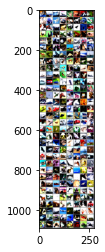

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images) 

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    get_test_accuracy(model, testloader, device)))

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of the network on the 10000 test images: 88.80 %




The accuracy 88.80 is far better than chance, which is 10% accuracy (randomly picking a class out of 10 classes).
Seems like the network learnt good.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of plane : 93 %
Accuracy of   car : 92 %
Accuracy of  bird : 100 %
Accuracy of   cat : 63 %
Accuracy of  deer : 92 %
Accuracy of   dog : 73 %
Accuracy of  frog : 77 %
Accuracy of horse : 100 %
Accuracy of  ship : 95 %
Accuracy of truck : 88 %


## Plot the performance metrics

In this step, the following metrics are plotted

i. Training Accuracy
ii. Test Accuracy

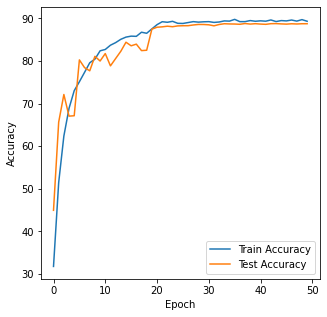

In [0]:
plot_accuracy(train_acc, test_acc)


## Display Misclassified Images

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


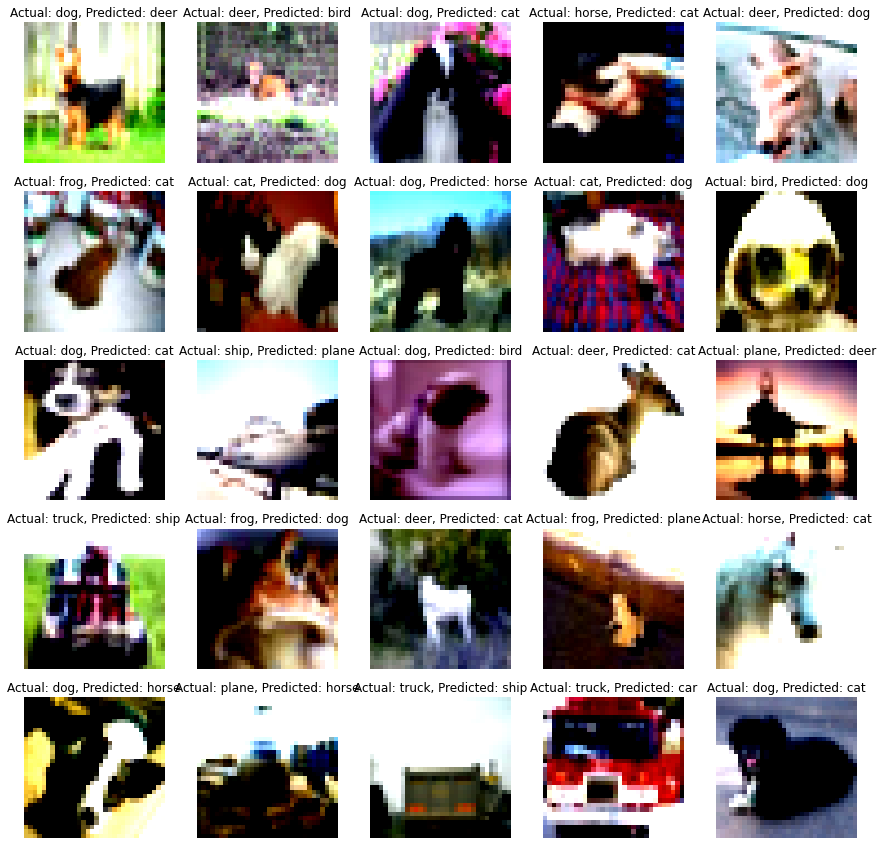

In [0]:
incorrect_images_list,predicted_label_list,correct_label_list=display_misclassfied_ciphar10_images(testloader, model, device, classes, 25)

In [0]:
incorrect_images=process_for_grad_cam(incorrect_images_list,predicted_label_list,correct_label_list,transform_test)

**Display GRADCAM for Misclassified Images**

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


torch.Size([25, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4
25


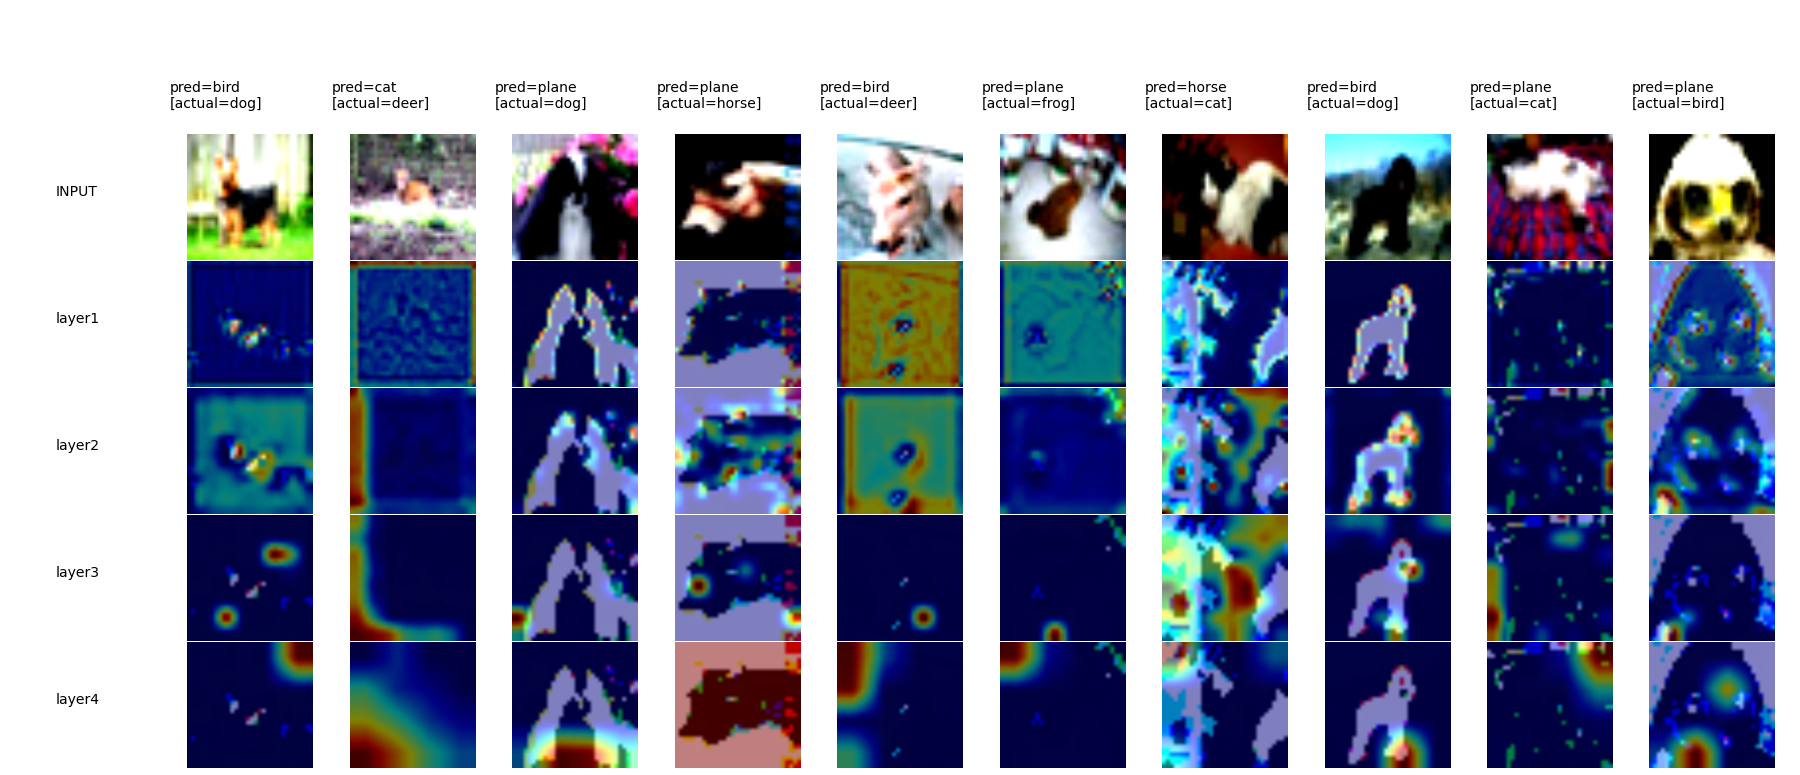

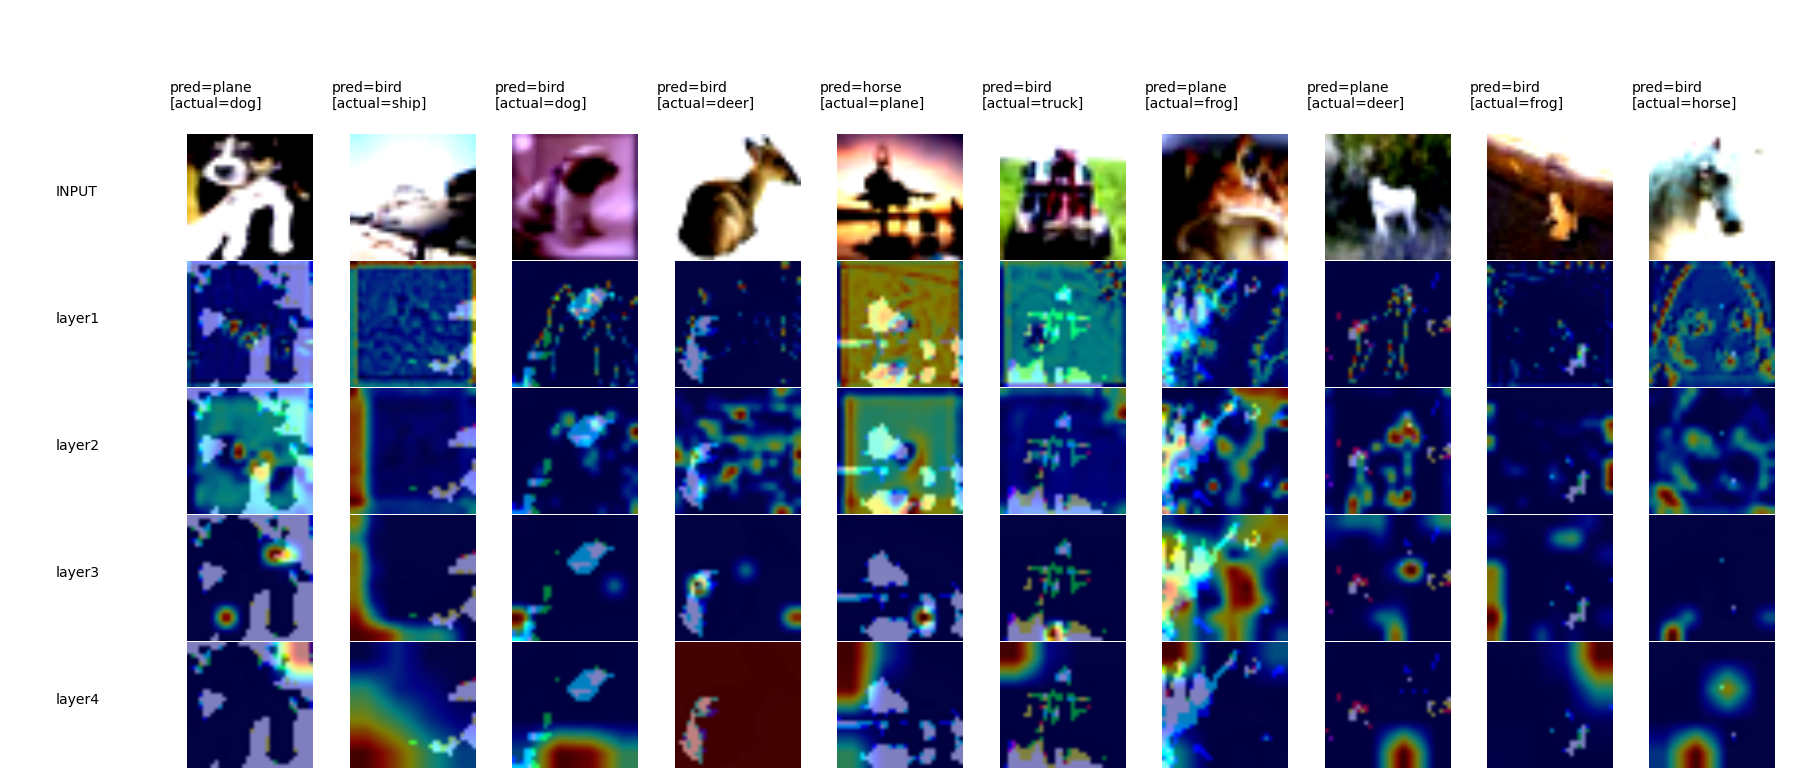

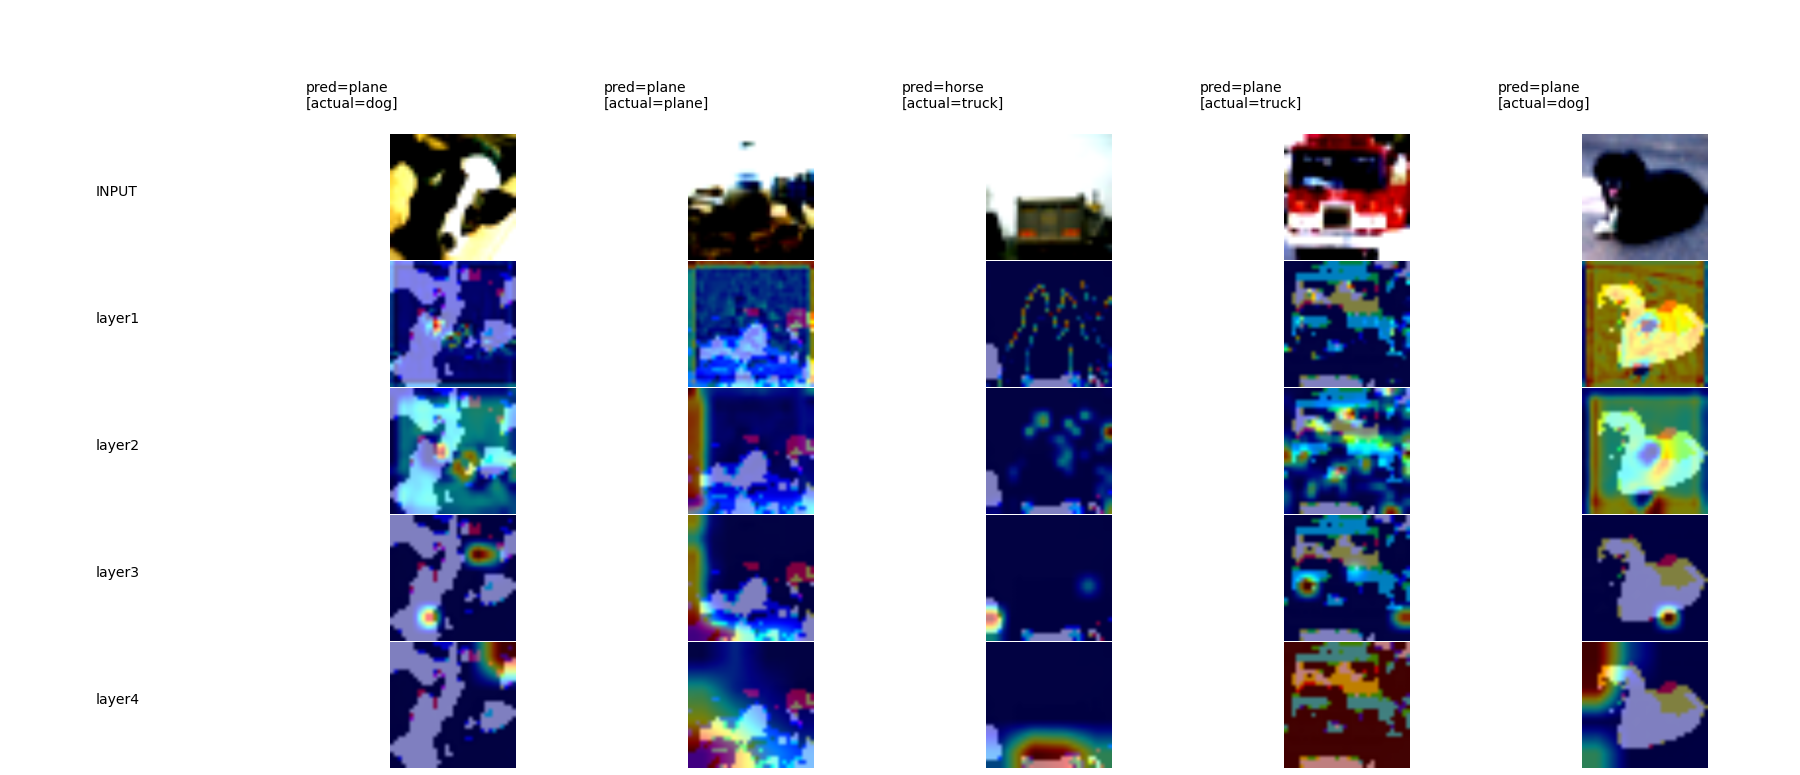

In [0]:
target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = GRADCAM(incorrect_images, correct_label_list[0:25], model, target_layers)
print(len(predicted_classes))
PLOTGRADCAM(gradcam_output, incorrect_images_list[0:25],incorrect_images ,correct_label_list[0:25], target_layers, classes, (3, 32, 32), predicted_classes)
